In [132]:
from sklearn.datasets import fetch_openml 
import matplotlib.pyplot as plt

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)



In [133]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (70000, 784), y shape: (70000,)


In [134]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(y == "0")[0] 
img8 = X[im8_idx].reshape(28, 28) 
plot_heatmap(img8)

In [135]:
from sklearn.model_selection import train_test_split
train_size, test_size = 1000, 1000 # Reshape to (n_samples, n_pixels_x, n_pixels_y) 
X = X.reshape((-1, 28, 28)) 
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666 ) 
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1000, 28, 28), y_train shape: (1000,)
X_test shape: (1000, 28, 28), y_test shape: (1000,)


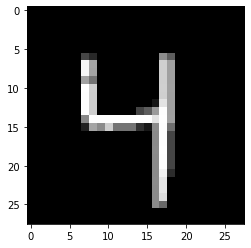

In [136]:
plt.imshow(X_test[5], cmap="gray")

Text(0.5, 1.0, 'Noisy Image with Random Noise')

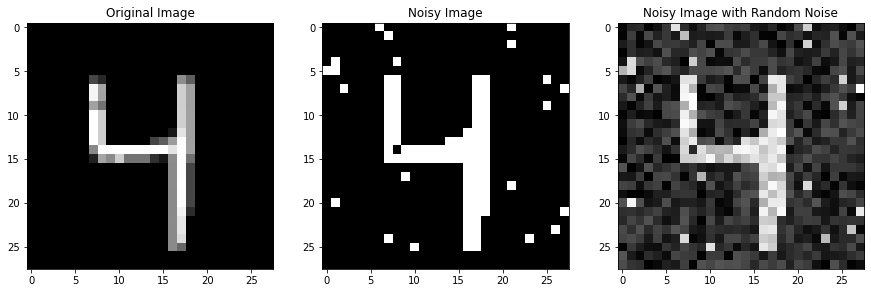

In [137]:
# distort X_train and X_test a little bit not using giotto

from skimage.util import random_noise
X_train_noisy = random_noise(X_train, mode="s&p",amount=0.05, seed=666)
X_test_noisy = random_noise(X_test, mode="s&p",amount=0.05, seed=666)

# generate random noise matrix of size X_train_noisy.shape and X_test_noisy.shape but without original image

X_train_noisy_random = np.random.rand(*X_train_noisy.shape)
X_test_noisy_random = np.random.rand(*X_test_noisy.shape)

# for each image in X_train_noisy and X_test_noisy, we will add the random noise matrix to the image

X_train_noisy_random = X_train_noisy + X_train_noisy_random
X_test_noisy_random = X_test_noisy + 0.5*X_test_noisy_random

# plot the original image, the noisy image and the noisy image with random noise

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(X_test[5], cmap="gray")
ax[0].set_title("Original Image")
ax[1].imshow(X_test_noisy[5], cmap="gray")
ax[1].set_title("Noisy Image")
ax[2].imshow(X_test_noisy_random[5], cmap="gray")
ax[2].set_title("Noisy Image with Random Noise")






(1000, 28, 28)


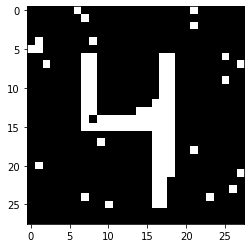

In [138]:
X_test_noisy.shape
plt.imshow(X_test_noisy[5], cmap="gray")
print(X_test_noisy.shape)

In [139]:
from gtda.images import Binarizer 

# Pick out index of first 8 image 
im8_idx = np.flatnonzero(y_train == "8")[0] # Reshape to (n_samples, n_pixels_x, n_pixels_y) format 
im8 = X_train[im8_idx][None, :, :] 
binarizer = Binarizer(threshold=0.4) 
im8_binarized = binarizer.fit_transform(im8) 
binarizer.plot(im8_binarized)


In [140]:
from gtda.images import RadialFiltration, HeightFiltration
radial_filtration = RadialFiltration(center=np.array([20,6])) 
im8_filtration = radial_filtration.fit_transform(im8_binarized) 
radial_filtration.plot(im8_filtration, colorscale="jet")


In [141]:
from gtda.homology import CubicalPersistence 
cubical_persistence = CubicalPersistence(n_jobs=-1) 
im8_cubical = cubical_persistence.fit_transform(im8_filtration) 
cubical_persistence.plot(im8_cubical)


In [142]:
from gtda.diagrams import Scaler 
scaler = Scaler() 
im8_scaled = scaler.fit_transform(im8_cubical) 
scaler.plot(im8_scaled)


In [143]:
from gtda.diagrams import HeatKernel
heat = HeatKernel(sigma=.15, n_bins=28, n_jobs=-1) 
im8_heat = heat.fit_transform(im8_scaled) # Visualise the heat kernel for H1 
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')




In [144]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

In [145]:
from gtda.diagrams import HeatKernel, PersistenceImage, BettiCurve, PersistenceLandscape, Silhouette

In [146]:
from sklearn.pipeline import make_pipeline, make_union 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from gtda.diagrams import PersistenceEntropy 
from gtda.images import HeightFiltration 
from sklearn.base import BaseEstimator, TransformerMixin
from gtda.images import Binarizer, RadialFiltration
from gtda.diagrams import PersistenceImage
import numpy as np


class ImageScalerAndFlattener(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        scaled_and_flattened_images = []
        for image in X:
            min_val, max_val = image.min(), image.max()
            scaled_image = (image - min_val) / (max_val - min_val) if max_val - min_val > 0 else image
            scaled_and_flattened_images.append(scaled_image.flatten())
        return np.array(scaled_and_flattened_images).reshape(-1, 1, 784)

class CombineTDAWithRawImages(BaseEstimator, TransformerMixin):
    def __init__(self, tda_pipeline, raw_image_pipeline):
        self.tda_pipeline = tda_pipeline
        self.raw_image_pipeline = raw_image_pipeline

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tda_features = self.tda_pipeline.transform(X).reshape(-1, 34, 28, 28)

        raw_images = self.raw_image_pipeline.transform(X).reshape(-1, 28, 28)

        raw_images_expanded = np.expand_dims(raw_images, axis=1).repeat(34, axis=1)

        combined_features = np.concatenate((tda_features, raw_images_expanded), axis=3)  

        return combined_features

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20], ] 

# Raw data processing - Scaling and normalization
raw_image_processing = Pipeline([('scaler_and_flattener', ImageScalerAndFlattener())])

# Creating a list of all filtration transformer
filtration_list = (
    [ HeightFiltration(direction=np.array(direction), n_jobs=-1) for direction in direction_list ] +
    [ RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline 
diagram_steps = [
    [ Binarizer(threshold=0.4, n_jobs=-1), filtration, CubicalPersistence(n_jobs=-1), Scaler(n_jobs=-1), ]
    for filtration in filtration_list
]

"""
# Listing all metrics we want to use to extract diagram amplitudes 

metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

"""

# feature_union 
feature_union = make_union(
    PersistenceImage(sigma=.05, n_bins=28, n_jobs=-1) # or heat kernel, or possibly any other (but rational and well-fitting to model) vector representation of the diagram
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

combined_features = CombineTDAWithRawImages(tda_union, raw_image_processing)

final_pipeline = Pipeline([('combine_features', combined_features)])


In [147]:
from sklearn import set_config 
set_config(display='diagram') 
final_pipeline


Pipeline(steps=[('combine_features',
                 CombineTDAWithRawImages(raw_image_pipeline=Pipeline(steps=[('scaler_and_flattener',
                                                                             ImageScalerAndFlattener())]),
                                         tda_pipeline=FeatureUnion(n_jobs=-1,
                                                                   transformer_list=[('pipeline-1',
                                                                                      Pipeline(steps=[('binarizer',
                                                                                                       Binarizer(n_jobs=-1,
                                                                                                                 threshold=0.4)),
                                                                                                      ('heightfiltration',
                                                                                                       HeightFiltration(direction=array([1, 0]),
                                                                                                                        n_jobs=-1...
                                                                                     ('pipeline-17',
                                                                                      Pipeline(steps=[('binarizer',
                                                                                                       Binarizer(n_jobs=-1,
                                                                                                                 threshold=0.4)),
                                                                                                      ('radialfiltration',
                                                                                                       RadialFiltration(center=array([20, 20]),
                                                                                                                        n_jobs=-1)),
                                                                                                      ('cubicalpersistence',
                                                                                                       CubicalPersistence(n_jobs=-1)),
                                                                                                      ('scaler',
                                                                                                       Scaler(n_jobs=-1)),
                                                                                                      ('featureunion',
                                                                                                       FeatureUnion(transformer_list=[('persistenceimage',
                                                                                                                                       PersistenceImage(n_bins=28,
                                                                                                                                                        n_jobs=-1,
                                                                                                                                                        sigma=0.05))]))]))])))])

In [148]:
X_train.shape

(1000, 28, 28)

In [150]:
X_training = tda_union.fit(X_train)
X_train_tda_clean = final_pipeline.fit_transform(X_train)
print(X_train_tda_clean.shape)

X_test_tda_clean = final_pipeline.transform(X_test)
print(X_test_tda_clean.shape)


(1000, 34, 28, 56)
(1000, 34, 28, 56)


In [151]:
X_train_tda_8 = final_pipeline.fit_transform(X_train_noisy_random) 
X_train_tda_8.shape




(1000, 34, 28, 56)

In [152]:
X_test_tda_8 = final_pipeline.transform(X_test_noisy_random)
X_test_tda_8.shape

(1000, 34, 28, 56)

In [153]:
X_train_tda_good = np.transpose(X_train_tda_8, (0, 3, 2, 1))
X_test_tda_good = np.transpose(X_test_tda_8, (0, 3, 2, 1))

In [154]:
X_train_tda_clean_good = np.transpose(X_train_tda_clean, (0, 3, 2, 1))
X_test_tda_clean_good = np.transpose(X_test_tda_clean, (0, 3, 2, 1))
#shapes
print(X_train_tda_good.shape)
print(X_test_tda_good.shape)

(1000, 56, 28, 34)
(1000, 56, 28, 34)


In [155]:
X_test_tda_good.shape

(1000, 56, 28, 34)

In [156]:
import tensorflow as tf

In [157]:
tf.keras.backend.clear_session()

In [158]:

model = tf.keras.models.Sequential()
#CNN
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(56, 28, 34)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 26, 32)        9824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 5, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 3, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [159]:
from tensorflow.keras.callbacks import EarlyStopping

In [160]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [161]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

model.fit(X_train_tda_clean_good, y_train, epochs=50, batch_size=1, validation_data=(X_test_tda_good, y_test), callbacks=[early_stopping])

Epoch 1/50
1000/1000 [==============================] - 5s 5ms/step - loss: 1.3480 - accuracy: 0.6050 - val_loss: 1.8292 - val_accuracy: 0.3380
Epoch 2/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5811 - accuracy: 0.8240 - val_loss: 1.2989 - val_accuracy: 0.5490
Epoch 3/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4437 - accuracy: 0.8740 - val_loss: 1.0906 - val_accuracy: 0.6300
Epoch 4/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2606 - accuracy: 0.9290 - val_loss: 1.1367 - val_accuracy: 0.6060
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2461 - accuracy: 0.9420 - val_loss: 1.3314 - val_accuracy: 0.5310
Epoch 6/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2540 - accuracy: 0.9320 - val_loss: 1.2347 - val_accuracy: 0.5510
Epoch 7/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1869 - accuracy: 0.9510 - val_loss: 0.7716 - val_accuracy:

In [162]:
score_tda = model.evaluate(X_test_tda_good, y_test, verbose=1)

32/32 [==============================] - 0s 10ms/step - loss: 0.7716 - accuracy: 0.7570


In [ ]:

# save x_test_tda and y_test
np.save('x_test_tda.npy', X_test_tda_good)
np.save('y_test.npy', y_test)


In [163]:
tf.keras.backend.clear_session()

In [164]:
# model standardowy bez tda
model2 = tf.keras.models.Sequential()
#CNN
model2.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              metrics=['accuracy'])

model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               7

In [165]:
import numpy as np
X_train_expanded = np.expand_dims(X_train, -1)
print(X_train_expanded.shape)
X_test_noisy_random_expanded = np.expand_dims(X_test_noisy_random, -1)
X_test_expanded = np.expand_dims(X_test, -1)
print(X_test_noisy_random_expanded.shape)
print(X_test_expanded.shape)

(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)


In [166]:
# fit model2
model2.fit(X_train_expanded, y_train, epochs=50, batch_size=1, validation_data=(X_test_noisy_random_expanded, y_test), callbacks=[early_stopping])

Epoch 1/50
1000/1000 [==============================] - 2s 2ms/step - loss: 2.0038 - accuracy: 0.5120 - val_loss: 2.3013 - val_accuracy: 0.1030
Epoch 2/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6940 - accuracy: 0.7860 - val_loss: 2.3006 - val_accuracy: 0.0980
Epoch 3/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4934 - accuracy: 0.8520 - val_loss: 2.3061 - val_accuracy: 0.0980
Epoch 4/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3320 - accuracy: 0.8980 - val_loss: 2.3022 - val_accuracy: 0.0980
Epoch 5/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3010 - accuracy: 0.9150 - val_loss: 2.3063 - val_accuracy: 0.0980
Epoch 6/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2519 - accuracy: 0.9350 - val_loss: 2.3073 - val_accuracy: 0.0980
Epoch 7/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2679 - accuracy: 0.9320 - val_loss: 2.3070 - val_accuracy:

In [167]:
score2 = model2.evaluate(X_test_noisy_random_expanded, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 2.3006 - accuracy: 0.0980


In [168]:
tf.keras.backend.clear_session()

In [169]:
# non convolutional model for standard mnist
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
                metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [170]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# fit model3
model3.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test_noisy_random, y_test), callbacks=[early_stopping])

Epoch 1/50
1000/1000 [==============================] - 1s 1ms/step - loss: 31.8558 - accuracy: 0.6270 - val_loss: 1.9107 - val_accuracy: 0.4190
Epoch 2/50
1000/1000 [==============================] - 1s 934us/step - loss: 6.4563 - accuracy: 0.8200 - val_loss: 2.0216 - val_accuracy: 0.5120
Epoch 3/50
1000/1000 [==============================] - 1s 944us/step - loss: 4.2178 - accuracy: 0.8560 - val_loss: 2.1180 - val_accuracy: 0.5030
Epoch 4/50
1000/1000 [==============================] - 1s 932us/step - loss: 2.9190 - accuracy: 0.8790 - val_loss: 2.0596 - val_accuracy: 0.4110
Epoch 5/50
1000/1000 [==============================] - 1s 937us/step - loss: 3.2011 - accuracy: 0.8840 - val_loss: 1.9435 - val_accuracy: 0.5630
Epoch 6/50
1000/1000 [==============================] - 1s 992us/step - loss: 3.0064 - accuracy: 0.8900 - val_loss: 2.2114 - val_accuracy: 0.2740
Epoch 7/50
1000/1000 [==============================] - 1s 939us/step - loss: 2.2638 - accuracy: 0.8850 - val_loss: 2.1277 - 

In [171]:
score3 = model3.evaluate(X_test_noisy_random, y_test)

32/32 [==============================] - 0s 772us/step - loss: 1.9107 - accuracy: 0.4190
